In [1]:
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg 
from pmdarima import auto_arima
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# ETH

## Step #1: Read Data

In [2]:
# Read data
df = pd.read_csv('../../../Project/.dataset/ETH-USD-3.2018-3.2024.csv', parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,856.012024,880.302002,851.919983,872.200012,872.200012,1868519936
1,2018-03-02,871.763977,876.377991,852.421997,856.853027,856.853027,1894419968
2,2018-03-03,856.710999,868.453979,855.206970,857.224976,857.224976,1699369984
3,2018-03-04,856.185974,867.950012,840.280029,866.677979,866.677979,1697939968
4,2018-03-05,866.846008,869.919983,853.520020,853.684021,853.684021,1898489984
...,...,...,...,...,...,...,...
2188,2024-02-26,3112.529053,3197.375000,3037.954590,3178.993652,3178.993652,17504464351
2189,2024-02-27,3178.405029,3287.958008,3167.830566,3244.519287,3244.519287,21090315368
2190,2024-02-28,3243.893311,3485.450928,3201.575928,3385.703857,3385.703857,32885894265
2191,2024-02-29,3386.802734,3518.969238,3303.905273,3341.919678,3341.919678,28469171094


## Step #2: Explore the Data

In [3]:
# Dataset Description
df = df.set_index('Date')
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Info: {df.info()}")
print(f"Dataset Describe: {df.describe()}")


Dataset Shape: (2193, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2193 entries, 2018-03-01 to 2024-03-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2193 non-null   float64
 1   High       2193 non-null   float64
 2   Low        2193 non-null   float64
 3   Close      2193 non-null   float64
 4   Adj Close  2193 non-null   float64
 5   Volume     2193 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 119.9 KB
Dataset Info: None
Dataset Describe:               Open         High          Low        Close    Adj Close  \
count  2193.000000  2193.000000  2193.000000  2193.000000  2193.000000   
mean   1297.763470  1333.670351  1258.664921  1298.754657  1298.754657   
std    1145.088942  1178.127207  1108.612995  1145.552190  1145.552190   
min      84.279694    85.342743    82.829887    84.308296    84.308296   
25%     228.976196   233.895996   222.996002   228.729996   228.729996  

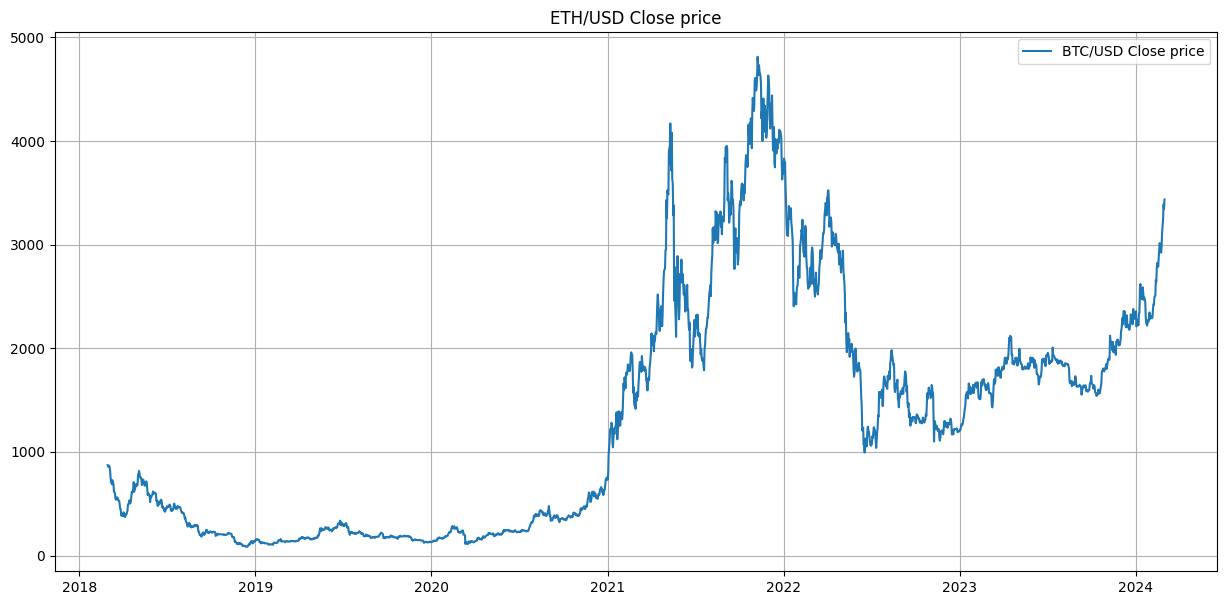

In [4]:
# Plotting data
plt.figure(figsize=(15, 7))
plt.plot(df.Close, label='BTC/USD Close price')
plt.title('ETH/USD Close price')
plt.grid()
plt.legend()
plt.show()



## Step #3: Feature Engineering

In [5]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    # 
    return df

                  Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                                                                                
2024-02-26  3178.993652    166.892555              3213.636211              2287.293305   2645.699069    2791.612321
2024-02-27  3244.519287    176.932341              3255.792315              2325.816376   2680.177885    2828.505781
2024-02-28  3385.703857    188.009064              3305.231037              2358.455071   2716.358445    2868.126115
2024-02-29  3341.919678    205.807441              3373.219591              2387.046254   2757.807129    2917.419234
2024-03-01  3435.053955    213.913899              3420.740673              2424.965577   2798.033335    2957.847847
                 Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                             

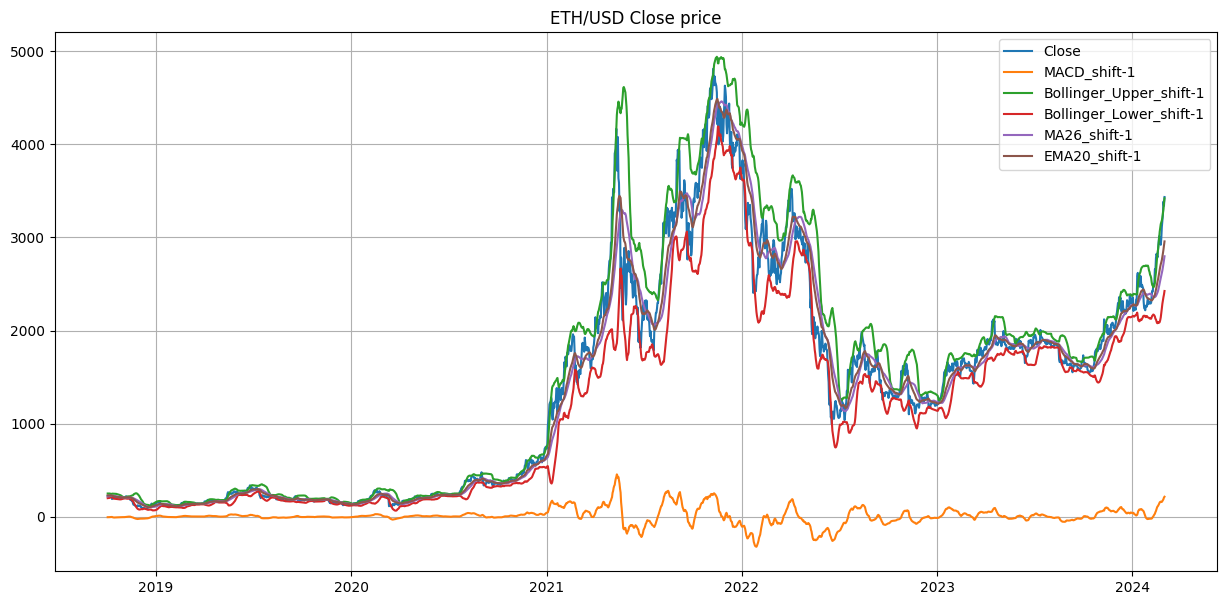

In [6]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]

# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()

df_original = df_filtered.copy()

# Create shifted features
for feature in FEATURES:
    if feature != 'Close':
        df_filtered[feature + '_shift-1'] = df_filtered[feature].shift(1)
        df_filtered = df_filtered.drop(feature, axis=1)

df_filtered = df_filtered.dropna()


print(df_filtered.tail().to_string())
print(df_filtered.head().to_string())
print(df_original.head().to_string())
print(df_original.tail().to_string())

# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('ETH/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()


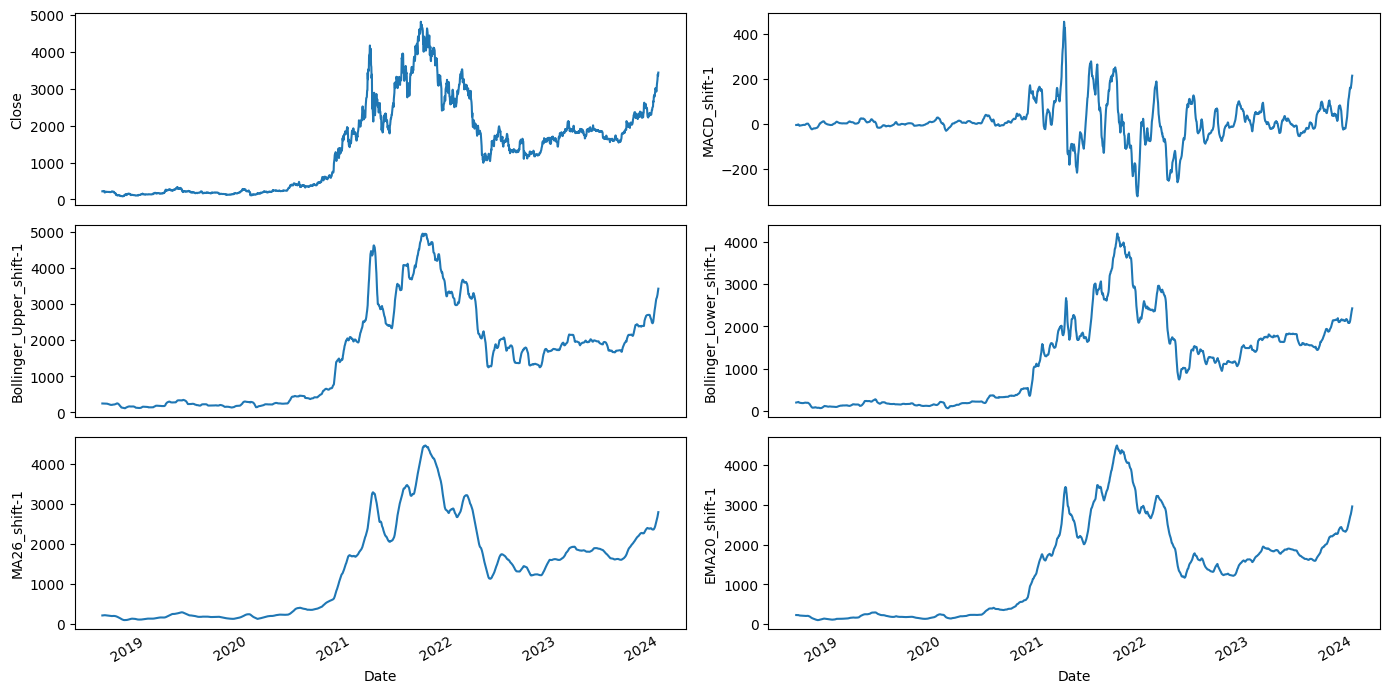

In [7]:
# Plot line charts
df_plot = df_filtered.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

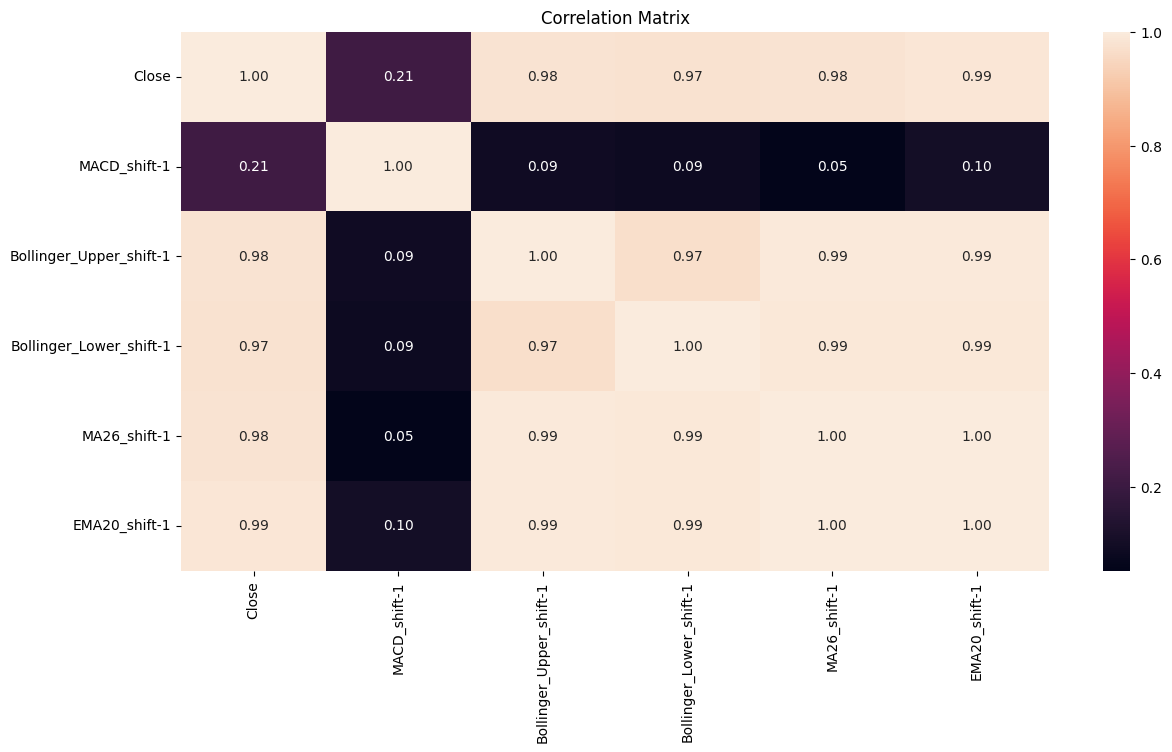

In [8]:
# Coorelation Matrix
plt.figure(figsize=(14, 7))
sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



## Step #4: Train & Test split

In [9]:
# Train-Test Split
def split_data(df, test_size=None):
    test_size = 0.2 if test_size is None else test_size
    split_row = len(df) - int(test_size * len(df))
    train_set = df.iloc[:split_row].copy()
    test_set = df.iloc[split_row:].copy()
    return train_set, test_set

train, test = split_data(df_filtered, test_size=0.3) 

In [10]:
print(df_filtered.shape)
print(train.shape)
print(test.shape)

(1977, 6)
(1384, 6)
(593, 6)


## Step #5: Model Specification

**ARIMAX**

**1. Check for stationary**

In [11]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag='AIC', regression='ct')
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (dftest[0] < dftest[4]["5%"] or dftest[0] < dftest[4]["1%"] or dftest[0] < dftest[4]["10%"]):
        print ("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print ("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False
      

In [12]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*"*50 + f" Differencing of order {diff_order} " + "*"*50)
    train_diff = pd.DataFrame(np.diff(train, diff_order, axis=0), columns=train.columns)
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'Close' -> p-value: 0.849
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MACD_shift-1' -> p-value: 0.001
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Upper_shift-1' -> p-value: 0.851
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'Bollinger_Lower_shift-1' -> p-value: 0.776
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MA26_shift-1' -> p-value: 0.873
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'EMA20_shift-1' -> p-value: 0.605
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'Close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'MACD_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF T

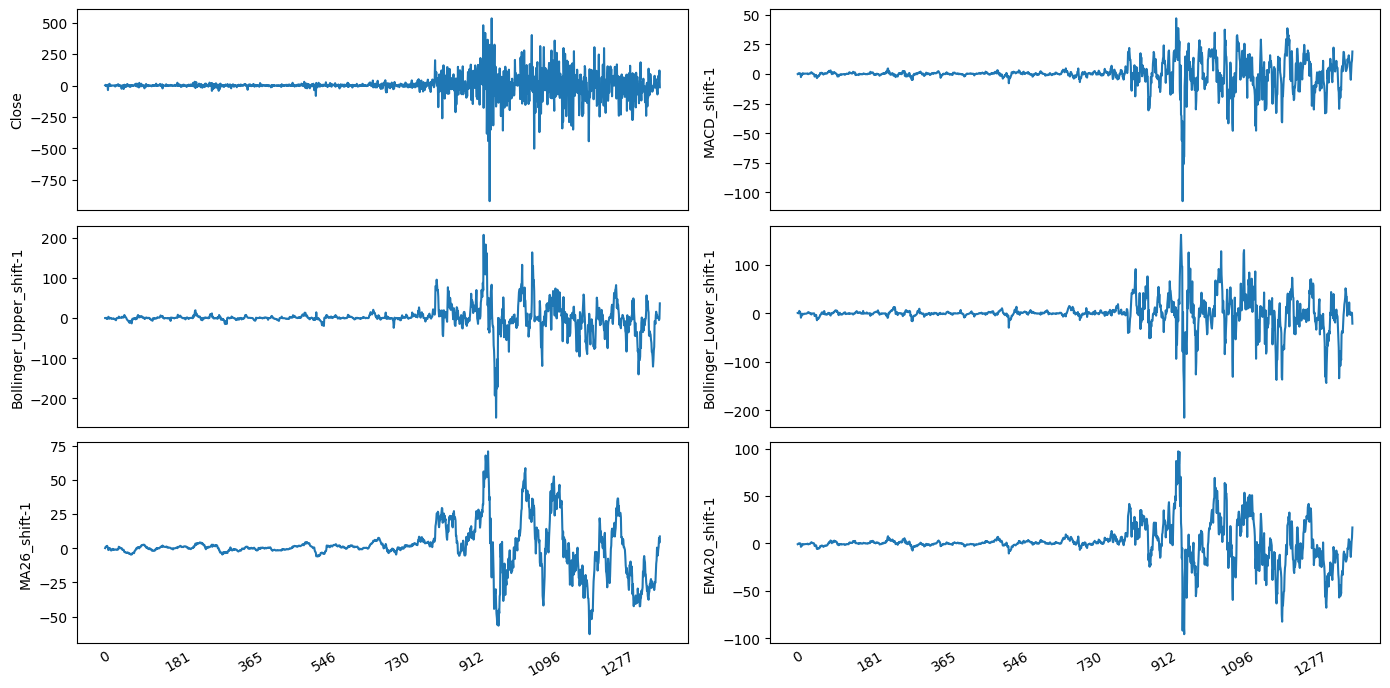

In [13]:
# Plot line charts
df_plot = train_diff.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'PACF')

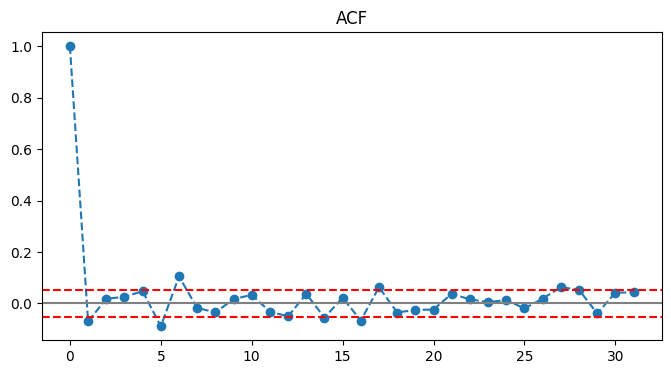

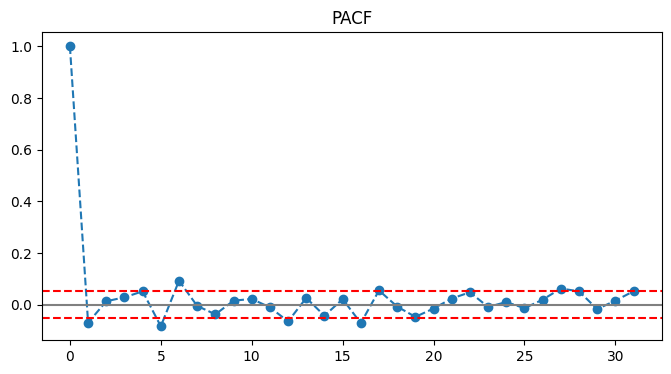

In [14]:
# Plot ACF and PACF
acf_plot = acf(train_diff['Close'])
pacf_plot = pacf(train_diff['Close'])
# Plot ACF
plt.figure(figsize=(8, 4))
plt.plot(acf_plot, marker='o', linestyle='--')
plt.axhline(y=0, color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)), color='red', linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(train_diff)), color='red', linestyle='--')
plt.title('ACF')

# Plot PACF
plt.figure(figsize=(8, 4))
plt.plot(pacf_plot, marker='o', linestyle='--')
plt.axhline(y=0, color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)), color='red', linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(train_diff)), color='red', linestyle='--')
plt.title('PACF')

**2. Choose the “p” level of AR model and “q” level for MA model**

In [15]:
# Find the best ARIMA model
def _arima_fit(orders, data, exog=None):
    models = dict()
    # Print arima fit with AIC and BIC decending
    for order in tqdm_notebook(orders):
        model = ARIMA(data, order=order, exog=exog)
        model_fit = model.fit()
        models[order] = model_fit
    return models

In [16]:
# Estimate ARIMA models with different p, q values through PCAF and ACF plots
list_q = [0, 1, 4, 5, 6] # q values picked from PACF plot
list_p = [0, 1, 4, 5, 6] # p values picked from ACF plot
order_list = list(product(list_p, [diff_order], list_q))

models = _arima_fit(order_list, train['Close'], train.drop(columns=['Close']))

  0%|          | 0/25 [00:00<?, ?it/s]

**3. Validation and tuning model**

In [17]:
# Validate the model with the validation set with AIC and BIC, then pick the best model based on RMSE
def _validate_models(models, valid, exog=None):
    # Get 10 top models based on AIC
    top_models = sorted(models.items(), key=lambda x: x[1].aic)[:10]
    print("Top 10 models based on AIC")
    for order, model in top_models:
        print(f"Order: {order} -> AIC: {model.aic:.2f}")
    # Validate the models
    best_model = None
    best_RMSE = float('inf')
    best_order = None
    for order, model in top_models:
        forecast = model.forecast(steps=len(valid), exog=exog)
        mse = np.mean((forecast - valid['Close'])**2)
        rmse = np.sqrt(mse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_model = model
            best_order = order
    return best_model, best_order, best_RMSE
        
        

# Validate the models
best_model, best_order, best_RMSE = _validate_models(models, test, test.drop(columns=['Close']))

print(f"\nBest Order: {best_order} -> Best RMSE: {best_RMSE:.2f}")
print(best_model.summary())

Top 10 models based on AIC
Order: (5, 1, 5) -> AIC: 16230.19
Order: (6, 1, 6) -> AIC: 16233.78
Order: (6, 1, 5) -> AIC: 16234.59
Order: (5, 1, 6) -> AIC: 16245.24
Order: (6, 1, 0) -> AIC: 16247.16
Order: (4, 1, 6) -> AIC: 16247.69
Order: (5, 1, 1) -> AIC: 16248.65
Order: (6, 1, 4) -> AIC: 16248.72
Order: (1, 1, 5) -> AIC: 16249.02
Order: (6, 1, 1) -> AIC: 16249.08

Best Order: (6, 1, 5) -> Best RMSE: 280.31
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1384
Model:                 ARIMA(6, 1, 5)   Log Likelihood               -8100.295
Date:                Tue, 28 May 2024   AIC                          16234.590
Time:                        11:58:39   BIC                          16323.535
Sample:                    10-03-2018   HQIC                         16267.860
                         - 07-17-2022                                         
Covariance Type:                  op

**4. Forecasting**

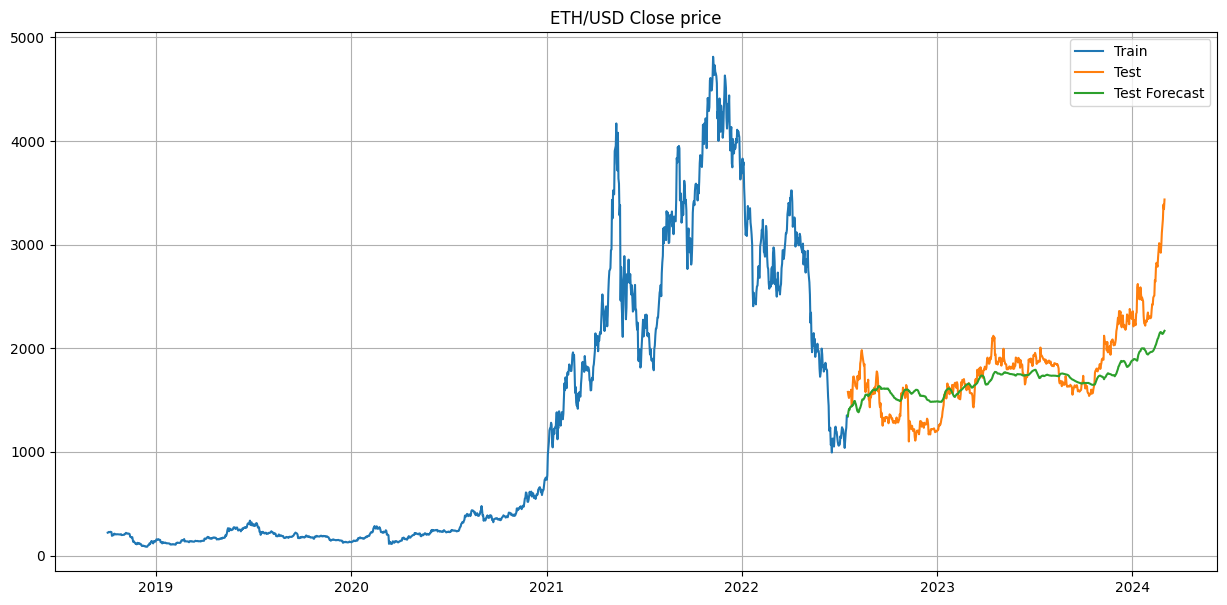

In [18]:
# Forecast on test set
# test forecast
forecast_test_valid = best_model.forecast(steps=len(test), exog=test.drop(columns=['Close']))
forecast_test_valid.index = test.index


# Plot the overall
plt.figure(figsize=(15, 7))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(forecast_test_valid, label='Test Forecast')
# plt.plot(forecast_next_30_days, label='Next 30 days Forecast')
plt.title('ETH/USD Close price')
plt.grid()
plt.legend()
plt.show()


In [19]:
# Create function to forecast next x days
def forecast_next_x_days(df, num_days, best_model):

    print(f"Forecasting for day {num_days}")
    # Predict 1 day ahead and use the forecasted value to create features for the next day
    df_forecast = df.copy()
    for i in range(num_days):
        # Create the forecast's exogenous variables
        future_exog_1 = df_forecast.iloc[-1].copy()
        print(f"Forecasting for day {i+1}")
        forecast_1_ahead = best_model.forecast(steps=1, exog=future_exog_1.drop('Close').values.reshape(1, -1))
        print(f"Forecasted value for day {i+1}: {forecast_1_ahead[0]}") 
        # Append the forecasted value to the dataset 
        future_exog_1['Close'] = forecast_1_ahead[0]
        df_forecast_extend = pd.DataFrame([future_exog_1], columns=df_forecast.columns)
        df_forecast = pd.concat([df_forecast, df_forecast_extend], axis=0)
        df_forecast.index = pd.date_range(start=df_forecast.index.min(), periods=len(df_forecast))
        
        # Create the features for the next day
        df_forecast = createFeatures(df_forecast)
        # Filter the data to the list of FEATURES
        df_forecast = df_forecast[FEATURES].copy()

        
    return df_forecast[-num_days:]
    

In [20]:
# Forecast next 30 days
forecast_next_30_days = forecast_next_x_days(df_original, 30, best_model)

# Forecast next 60 days
forecast_next_60_days = forecast_next_x_days(df_original, 60, best_model)

# Forecast next 90 days
forecast_next_90_days = forecast_next_x_days(df_original, 90, best_model)

Forecasting for day 30
Forecasting for day 1
Forecasted value for day 1: 1933.0360085393445
Forecasting for day 2
Forecasted value for day 2: 1965.9254919283767
Forecasting for day 3
Forecasted value for day 3: 1991.5358779129801
Forecasting for day 4
Forecasted value for day 4: 2003.0389869528071
Forecasting for day 5
Forecasted value for day 5: 2015.7485022755864
Forecasting for day 6
Forecasted value for day 6: 2025.3028491215
Forecasting for day 7
Forecasted value for day 7: 2030.1602608702756
Forecasting for day 8
Forecasted value for day 8: 2032.1531085597485
Forecasting for day 9
Forecasted value for day 9: 2037.0975871411179
Forecasting for day 10
Forecasted value for day 10: 2043.4780214705256
Forecasting for day 11
Forecasted value for day 11: 2051.1670594726597
Forecasting for day 12
Forecasted value for day 12: 2057.104709073746
Forecasting for day 13
Forecasted value for day 13: 2062.8218922138717
Forecasting for day 14
Forecasted value for day 14: 2067.317154235358
Foreca

Text(0.5, 1.0, 'ETH/USD Close price')

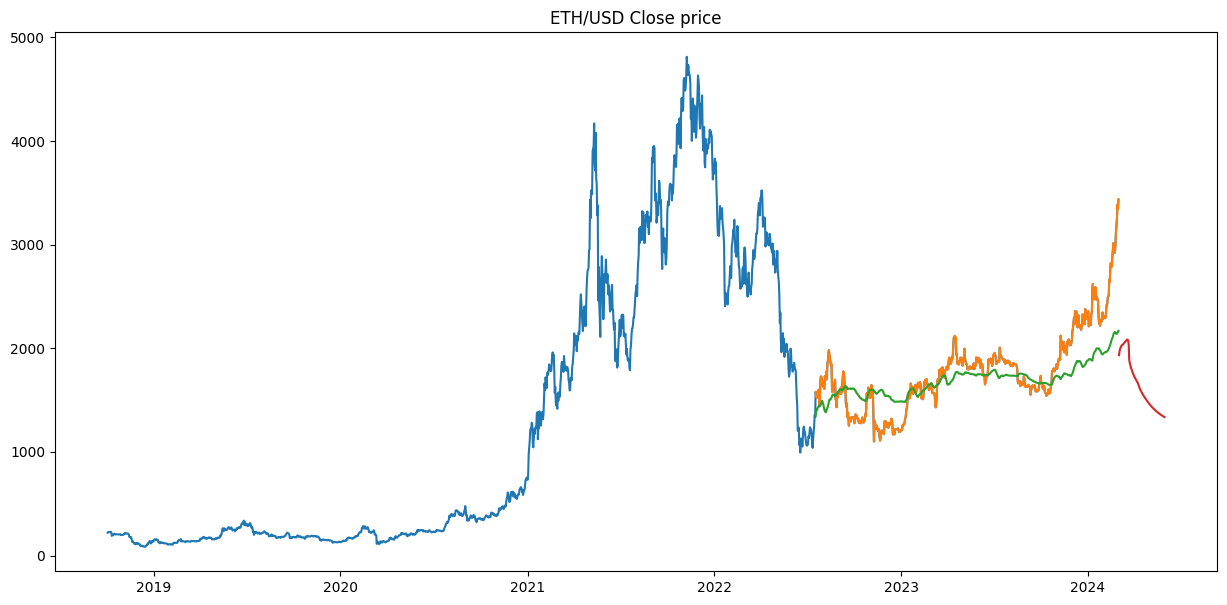

In [21]:
# Create df_forecast with index
df_forecast = forecast_next_90_days
df_forecast.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast))

# Plot the overall with connection to forecast
plt.figure(figsize=(15, 7))
plt.plot(df_filtered['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(forecast_test_valid, label='Test Forecast')
plt.plot(df_forecast['Close'], label='Forecast')
plt.title('ETH/USD Close price')

## Step #6: Model Evaluation

In [22]:
# Calculate the Model's RMSE, MAPE, and SMAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape

# Calculate the metrics
rmse, mape, smape = calculate_metrics(test['Close'], forecast_test_valid)
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"SMAPE: {smape:.2f}")


RMSE: 280.31
MAPE: 11.29
SMAPE: 11.47
